# 0. Install and Import dependencies

In [176]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [177]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3, DQN, HER

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import quantstats as qs

In [178]:
# Specify parameters
STOCK_NAME = 'TSLA'

# Window size for training
TRAIN_WINDOW_SIZE = 10
TRAIN_START = '2020-01-01'
TRAIN_END = '2022-12-31'

TEST_WINDOW_SIZE = 10

# Indicator parameters
SMA_PERIOD = 10

# 1. Get Data

In [179]:
import yfinance as yf

df = yf.Ticker(STOCK_NAME)
df = df.history(period="max")
df = df.loc[TRAIN_START:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1083, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500


In [180]:
TRAIN_ENV_FRAME_BOUND = (TRAIN_WINDOW_SIZE, df[TRAIN_START:TRAIN_END].shape[0])
TEST_ENV_FRAME_BOUND = (df[TRAIN_START:TRAIN_END].shape[0], df.shape[0])

In [181]:
df[TRAIN_START:TRAIN_END]

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,126.370003,128.619995,121.019997,123.150002,166989700
2022-12-27 00:00:00-05:00,117.500000,119.669998,108.760002,109.099998,208643400
2022-12-28 00:00:00-05:00,110.349998,116.269997,108.239998,112.709999,221070500


# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [182]:
from gym_anytrading.envs import StocksEnv
from finta import TA

from ta.trend import MACD, CCIIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
from ta.volatility import KeltnerChannel
from ta.trend import IchimokuIndicator

In [183]:
# Add SMA
df['SMA'] = TA.SMA(df, period=SMA_PERIOD)  # Make sure SMA_PERIOD is defined

# Add EMA
df['EMA'] = TA.EMA(df, period=20)  # You can adjust the period as needed

# Add RSI (you already have this)
rsi = RSIIndicator(close=df['Close'])
df['RSI'] = rsi.rsi()

# Add MACD
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()

# Add Bollinger Bands
bollinger_bands = BollingerBands(close=df['Close'])
df['BB_UPPER'] = bollinger_bands.bollinger_hband()
df['BB_LOWER'] = bollinger_bands.bollinger_lband()
df['BB_MIDDLE'] = bollinger_bands.bollinger_mavg()

# Add Stochastic Oscillator
# stoch = TA.STOCH(df)
# df['STOCH_K'] = stoch['%K']
# df['STOCH_D'] = stoch['%D']

# Add Average True Range
df['ATR'] = TA.ATR(df)

# Add OBV (you already have this)
df['OBV'] = TA.OBV(df)

# Add Commodity Channel Index (CCI)
cci = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20)
df['CCI'] = cci.cci()

# Add Rate of Change (ROC)
df['ROC'] = TA.ROC(df, period=10)  # Default window is 10, adjust as needed

# Add Chaikin Money Flow (CMF)
cmf = ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=20)
df['CMF'] = cmf.chaikin_money_flow()

# Add Force Index
df['Force_Index'] = (df['Close'].diff(1) * df['Volume']).fillna(0)

# Add Keltner Channel
keltner = TA.KC(df, period=20)  # Default window is 20, adjust as needed
kc = KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'], window=20)
# Add Keltner Channel values to DataFrame
df['KC_UPPER'] = kc.keltner_channel_hband()
df['KC_LOWER'] = kc.keltner_channel_lband()
df['KC_MIDDLE'] = kc.keltner_channel_mband() 

# Add Parabolic SAR
df['SAR'] = TA.SAR(df)  # Parameters can be adjusted for sensitivity

# Add Ichimoku Cloud
ichimoku = TA.ICHIMOKU(df)  # The window sizes can be adjusted if necessary
from ta.trend import IchimokuIndicator

# Add Ichimoku Indicator
from ta.trend import IchimokuIndicator

# Initialize Ichimoku Indicator using the 'High' and 'Low' columns of your DataFrame
ichimoku_indicator = IchimokuIndicator(
    high=df['High'], 
    low=df['Low'], 
    window1=9, 
    window2=26, 
    window3=52,
    visual=False,  # If True, shift window2 (n2) period forward for visualization purposes
    fillna=False   # Set to True if you want to fill NA values
)

# Access the Ichimoku Cloud components
df['ICHIMOKU_A'] = ichimoku_indicator.ichimoku_a()
df['ICHIMOKU_B'] = ichimoku_indicator.ichimoku_b()
df['ICHIMOKU_BASE_LINE'] = ichimoku_indicator.ichimoku_base_line()
df['ICHIMOKU_CONVERSION_LINE'] = ichimoku_indicator.ichimoku_conversion_line()

# Handle NaN values for newly added indicators
df.fillna(0, inplace=True)

In [184]:
df

,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,BB_UPPER,...,CMF,Force_Index,KC_UPPER,KC_LOWER,KC_MIDDLE,SAR,ICHIMOKU_A,ICHIMOKU_B,ICHIMOKU_BASE_LINE,ICHIMOKU_CONVERSION_LINE
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.000000,28.684000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,29.103111,27.904445,0.000000,22.022052,0.000000,28.413667,0.000000,0.000000
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.000000,29.130250,0.000000,0.000000,0.000000,...,0.000000,2.266760e+08,29.942333,28.204334,0.000000,22.155878,0.000000,29.190333,0.000000,0.000000
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.000000,29.487316,0.000000,0.000000,0.000000,...,0.000000,8.643446e+07,30.167333,28.494889,0.000000,22.480309,0.000000,29.190333,0.000000,0.000000
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.000000,30.002141,0.000000,0.000000,0.000000,...,0.000000,3.132942e+08,30.674722,28.811389,0.000000,22.791764,0.000000,29.778000,0.000000,0.000000
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.000000,30.681177,0.000000,0.000000,0.000000,...,0.000000,7.188109e+08,31.427066,29.129467,0.000000,23.310778,0.000000,30.673333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16 00:00:00-04:00,156.740005,158.190002,153.750000,157.110001,97000000,169.025000,171.280410,35.977768,-4.504317,182.259009,...,0.078108,-4.238895e+08,177.577169,165.073165,171.325167,179.092669,167.742500,179.675003,169.000000,166.485001
2024-04-17 00:00:00-04:00,157.639999,158.330002,153.779999,155.449997,82439700,167.731999,169.772752,34.989351,-5.231105,183.514569,...,0.047572,-1.368502e+08,176.801335,164.382332,170.591834,177.572109,167.742500,179.675003,169.000000,166.485001
2024-04-18 00:00:00-04:00,151.250000,152.199997,148.699997,149.929993,96098800,165.613998,167.882965,31.855324,-6.181254,184.840897,...,-0.003157,-5.304658e+08,175.506502,163.280498,169.393500,176.142782,165.217499,177.150002,166.474998,163.959999


## 2.1.4. Create New Environments

In [185]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, :].to_numpy()[start:end]
    return prices, signal_features

In [186]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [187]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=TRAIN_WINDOW_SIZE)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [188]:
print()
print("custom_env information:")
print("> shape:", env2.unwrapped.shape)
print("> df.shape:", env2.unwrapped.df.shape)
print("> prices.shape:", env2.unwrapped.prices.shape)
print("> signal_features.shape:", env2.unwrapped.signal_features.shape)
print("> max_possible_profit:", env2.unwrapped.max_possible_profit())


custom_env information:
> shape: (10, 26)
> df.shape: (1083, 26)
> prices.shape: (756,)
> signal_features.shape: (756, 26)
> max_possible_profit: 235144.2459428843


In [189]:
env2.signal_features

array([[ 28.29999924,  28.71333313,  28.11400032, ...,  28.41366673,
          0.        ,   0.        ],
       [ 29.36666679,  30.26666641,  29.12800026, ...,  29.19033337,
          0.        ,   0.        ],
       [ 29.36466789,  30.10400009,  29.33333206, ...,  29.19033337,
          0.        ,   0.        ],
       ...,
       [110.34999847, 116.26999664, 108.23999786, ..., 172.81999588,
        153.57999802, 134.61500168],
       [120.38999939, 123.56999969, 117.5       , ..., 172.81999588,
        153.57999802, 134.61500168],
       [119.94999695, 124.48000336, 119.75      , ..., 172.81999588,
        153.57999802, 131.74499893]])

In [190]:
env2.signal_features.shape

(756, 26)

In [191]:
# model = A2C('MlpPolicy', env, verbose=0) 
# model.learn(total_timesteps=10000)

In [192]:
from sb3_contrib import RecurrentPPO

model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, seed=2023)
model.learn(total_timesteps=10) # to be changed

Using cpu device
----------------------------
| time/              |     |
|    fps             | 400 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------


# 4. Evaluation

In [193]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=TEST_WINDOW_SIZE)
observation, info = env.reset()
while True: 
    observation = observation.reshape(TRAIN_WINDOW_SIZE, env2.signal_features.shape[1]) 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 83.1426773071289, 'total_profit': 0.44138637742443854, 'position': <Positions.Short: 0>}


no additional features: info {'total_reward': 2.830047607421875, 'total_profit': 0.37571004494989807, 'position': <Positions.Short: 0>}

'SMA': info {'total_reward': 15.360054016113281, 'total_profit': 0.30604104987037384, 'position': <Positions.Long: 1>}

'SMA', 'EMA', 'RSI', 'MCAD': info {'total_reward': -1.96002197265625, 'total_profit': 0.32539209565950067, 'position': <Positions.Long: 1>}

'SMA', 'EMA', 'RSI', 'MCAD', 'ATR', 'OBV': info {'total_reward': 70.35005187988281, 'total_profit': 0.39910756532600355, 'position': <Positions.Long: 1>}

'SMA', 'EMA', 'RSI', 'MCAD', 'ATR', 'OBV', 'BB_UPPER', 'BB_LOWER', 'BB_MIDDLE': info {'total_reward': -31.859947204589844, 'total_profit': 0.25073653815539027, 'position': <Positions.Long: 1>}

all: info {'total_reward': 83.1426773071289, 'total_profit': 0.44138637742443854, 'position': <Positions.Short: 0>}

More features, better for TSLA.

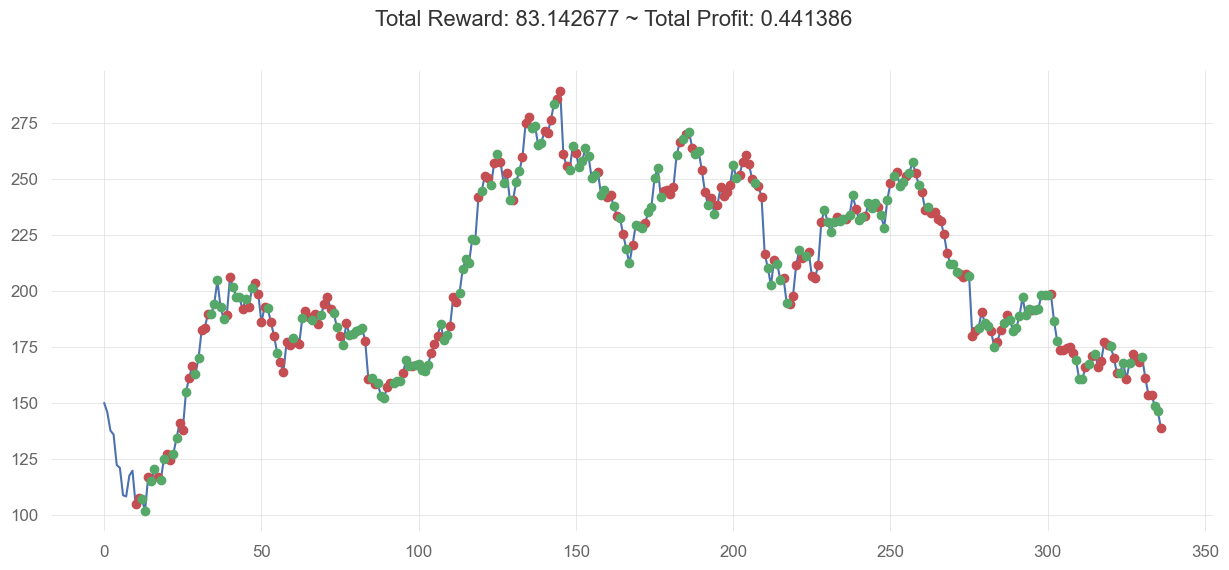

In [194]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 5. QuantStats

                           Strategy
-------------------------  ----------
Start Period               2023-01-05
End Period                 2024-04-22
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -55.86%
CAGR﹪                     -35.32%

Sharpe                     -1.63
Prob. Sharpe Ratio         4.87%
Smart Sharpe               -1.61
Sortino                    -2.27
Smart Sortino              -2.25
Sortino/√2                 -1.6
Smart Sortino/√2           -1.59
Omega                      0.55

Max Drawdown               -69.47%
Longest DD Days            434
Volatility (ann.)          35.21%
Calmar                     -0.51
Skew                       1.62
Kurtosis                   28.19

Expected Daily %           -0.25%
Expected Monthly %         -4.98%
Expected Yearly %          -33.56%
Kelly Criterion            -28.33%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.88%
Expected Shortfall (cVaR)  -3.88%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-02-14,2024-04-22,2024-04-22,433,-69.467627,-64.742058


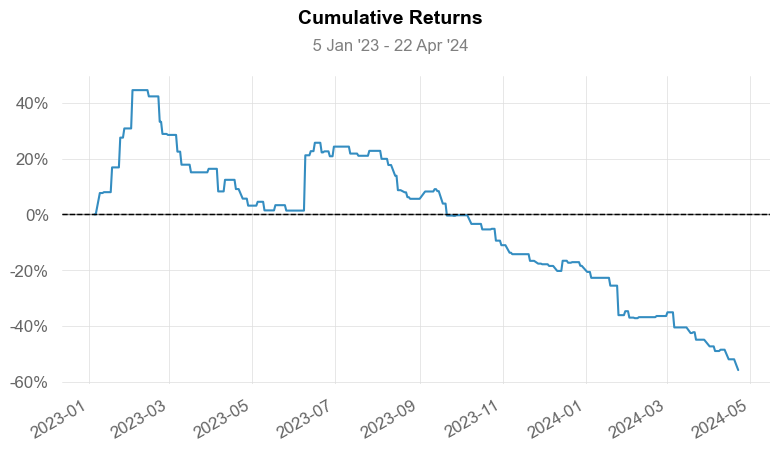

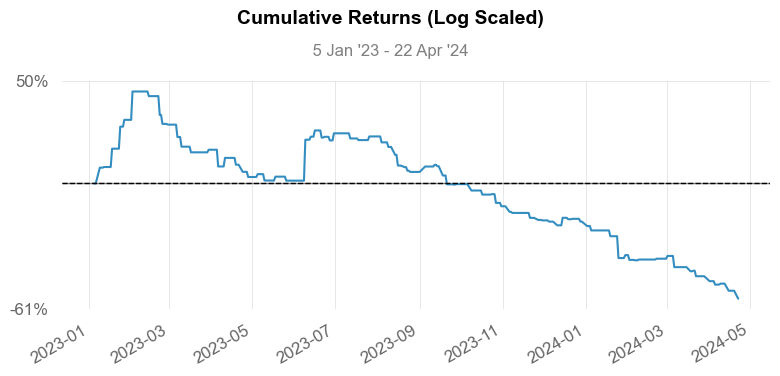

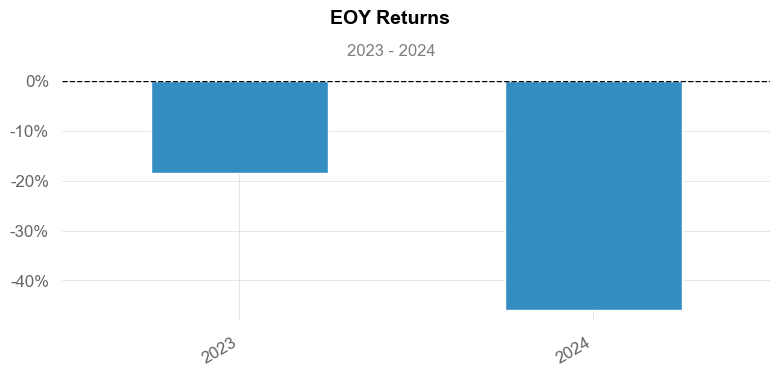

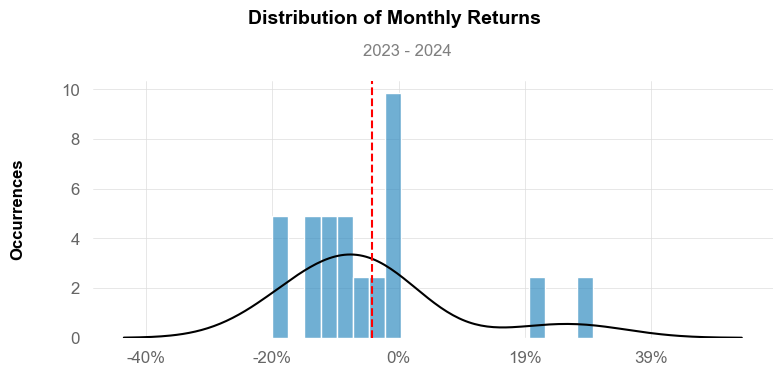

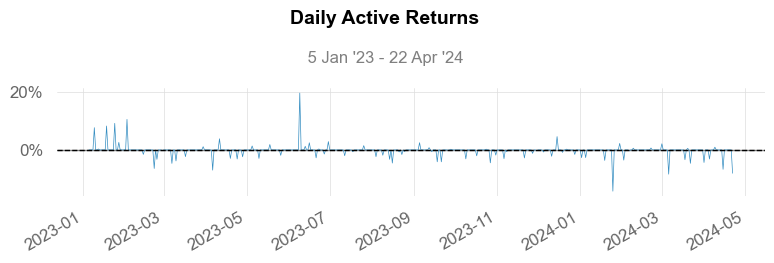

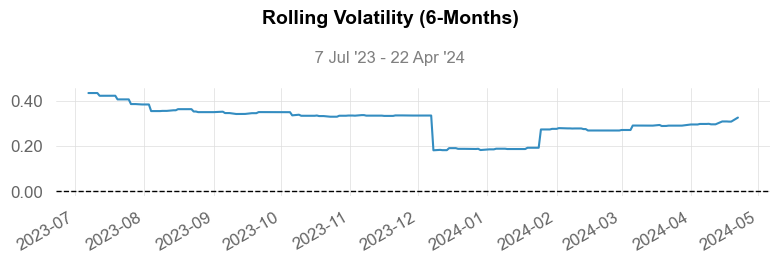

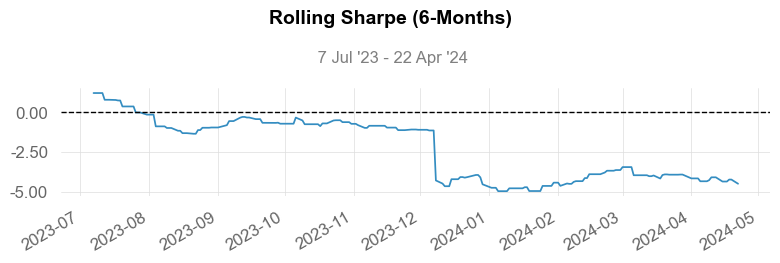

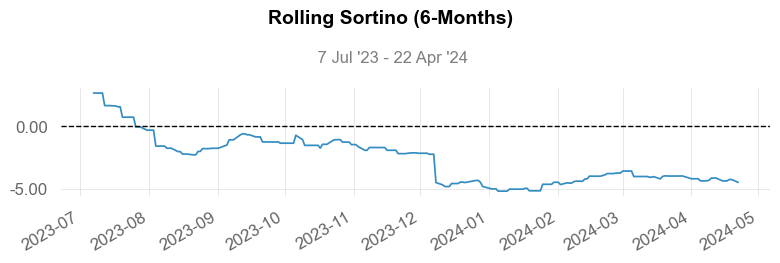

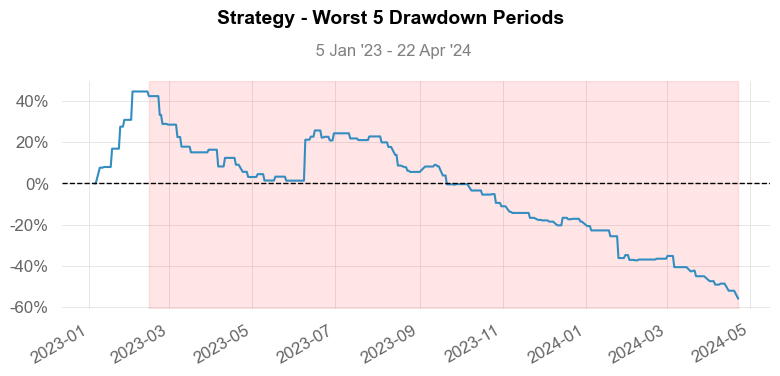

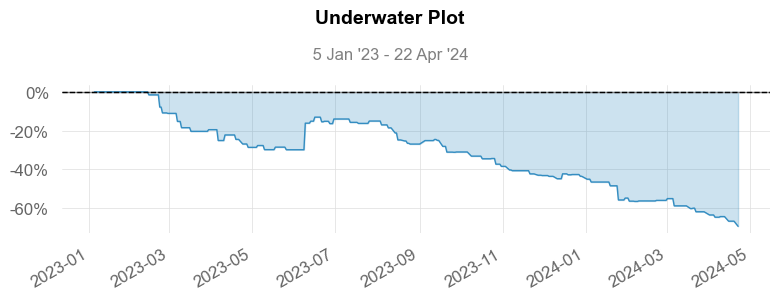

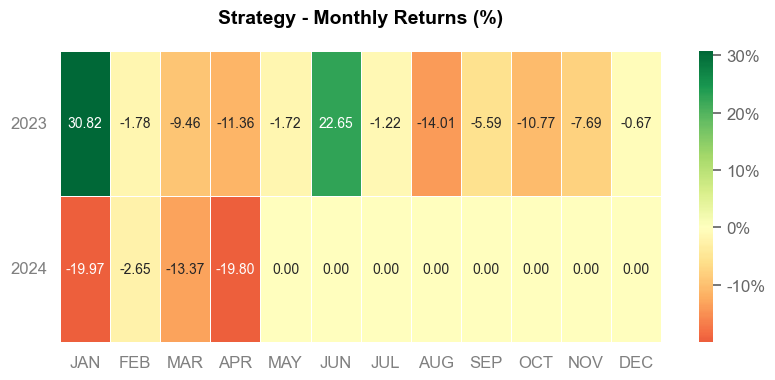

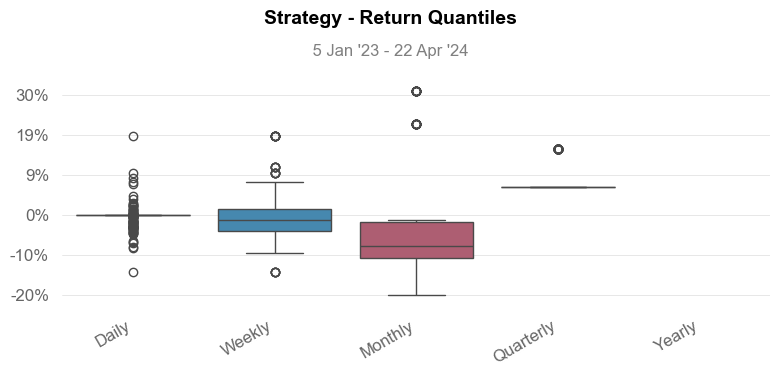

In [195]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

In [196]:
qs.reports.html(returns, output=f"quantstats-{STOCK_NAME}.html")